In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate 

import qiime2

In [1]:
%cd /storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_550


## 1. read and separate data between two subjects

In [86]:
FEATURE_TABLE_FILE = 'raw_data/550_reference.tsv'
METADATA_FILE = 'raw_data/550_metadata.txt'

In [87]:
#read feature table and metadata
feature_table = pd.read_csv(FEATURE_TABLE_FILE, sep = '\t', skiprows = [0], index_col=[0])
metadata = pd.read_csv(METADATA_FILE, sep = '\t')

In [89]:
#remove mislabeled data and select only gut microbiome samples
metadata =  metadata[(metadata['mislabeled'] == False) & (metadata['body_site'] == 'UBERON:feces')]

#separate female from male samples
male_samples = metadata[metadata['sex'] == 'male']['sample_name']
female_samples = metadata[metadata['sex'] == 'female']['sample_name']

In [90]:
print('no of M subject samples: {}, no of F subject samples: {}'.format(len(male_samples), len(female_samples)))

no of M subject samples: 332, no of F subject samples: 130


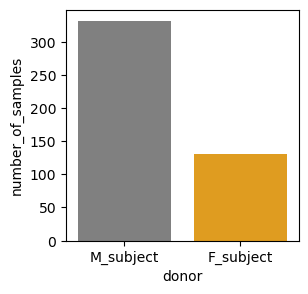

In [91]:
samples_df = pd.DataFrame(list(zip(['M_subject', 'F_subject'], [len(male_samples), len(female_samples)])),
                          columns = ['donor', 'number_of_samples'])

plt.figure(figsize = [3, 3])
sns.barplot(data = samples_df,
            x = 'donor',
            y='number_of_samples',
            palette = ['Grey', 'Orange']
           )
plt.show()

## 2. interpolate using nearest interpolation



In [106]:
#make dictionary with sample name and time step
sample_to_day_dict = dict(zip(metadata['sample_name'], metadata['days_since_experiment_start']))

#filter male and female data
male_df = feature_table[male_samples]
female_df = feature_table[female_samples]

#change column names into days_since_experiment_start and remove otus that are 0 in all timesteps
male_timestep_df = male_df.rename(columns=sample_to_day_dict).T.sort_index()
male_timestep_df = male_timestep_df.loc[:, male_timestep_df.any()]

female_timestep_df = female_df.rename(columns=sample_to_day_dict).T.sort_index()
female_timestep_df = female_timestep_df.loc[:, female_timestep_df.any()]

In [107]:
#check missing timepoints
def calcualte_missing_points(df):

    full_timepoints = [i for i in range(0, int(df.index[-1]))]
    missing_timepoints  = list(set(full_timepoints) - set(df.index))
    
    return len(missing_timepoints)

print('number of missing days for donor A is: {} and for donor B: {}'.format(calcualte_missing_points(male_timestep_df), calcualte_missing_points(female_timestep_df)))

number of missing days for donor A is: 111 and for donor B: 56


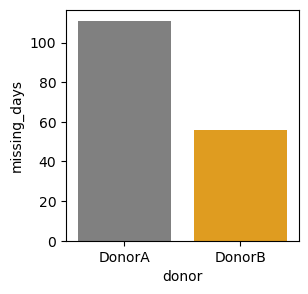

In [108]:
#plot missing timepoints
missing_days_df = pd.DataFrame(list(zip(['DonorA', 'DonorB'],
                                        [calcualte_missing_points(male_timestep_df), calcualte_missing_points(female_timestep_df)])),
                               columns = ['donor', 'missing_days'])

plt.figure(figsize = [3, 3])
sns.barplot(data = missing_days_df,
            x = 'donor',
            y='missing_days',
            palette = ['Grey', 'Orange']
           )
plt.show()

In [109]:
def nearest_interp(col, masked_df):
        
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #nodes
    interpolated_nodes = tmp[tmp.isna()].index.tolist() #this is being interpolated
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='nearest', 
                            fill_value="extrapolate")
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

#interpolate dataframe using nearest interpolation method
def interpolate_data(df):
    
    #check how many points are missing
    full_df = list(range(0, int(df.index[-1])))
    missing_tpoints = list(set(full_df) - set(df.index.astype(int)))

    #add missing rows to out dataframe
    df_with_missing_tpoints = df.reindex(df.index.union(missing_tpoints))

    #dataframe with only missing timepoints
    masked_df = df_with_missing_tpoints.loc[missing_tpoints]

    #missing timepoints 
    print(df_with_missing_tpoints.isna().sum()[0] )
    
    #interpolate
    interpolated_timepoints = []
    for col in df_with_missing_tpoints.columns:
        y = nearest_interp(col, df_with_missing_tpoints)
        interpolated_timepoints.append(y)
        
    nearest_df = pd.concat(interpolated_timepoints, axis=1)

    return nearest_df

In [114]:
interpolated_male_df = interpolate_data(male_timestep_df)
interpolated_female_df = interpolate_data(female_timestep_df)

111
56


In [76]:
%mkdir data_processing/interpolation_rarefaction

In [119]:
interpolated_male_df.T.to_csv('data_processing/interpolation_rarefaction/interpolated_male_df.csv', sep = '\t')
interpolated_female_df.T.to_csv('data_processing/interpolation_rarefaction/interpolated_female_df.csv', sep = '\t')

## 3. rarefy

In [ ]:
#convert file to biom format
biom convert -i interpolated_male_df.csv -o interpolated_male_df.biom --table-type="OTU table" --to-hdf5
biom convert -i interpolated_female_df.csv -o interpolated_female_df.biom --table-type="OTU table" --to-hdf5

In [120]:
%cd data_processing/interpolation_rarefaction

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/data_processing/interpolation_rarefaction


In [124]:
def rarefy_table(biom_file):
    
    unrarefied_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", biom_file)
    #rarefy
    rarefy_result = rarefy(table=unrarefied_table, sampling_depth=16000)
    rarefied_table = rarefy_result.rarefied_table
    rarefied_table_df = rarefied_table.view(pd.DataFrame)
    
    return rarefied_table_df

In [127]:
male_interpolated_rarefied_df = rarefy_table('interpolated_male_df.biom')
female_interpolated_rarefied_df = rarefy_table('interpolated_female_df.biom')

## 4. reinterpolate missing timepoints that were lost after rarefaction

In [126]:
def reinterpolate_data(df):
    
    missing_timepoints_after_rarefaction = list(set([float(i) for i in range(0, df.shape[0])]) - set(df.index.astype(float)))
    rarefied_df_with_missing_tpoints = df.reindex(df.index.union(missing_timepoints_after_rarefaction))
    rarefied_df_with_missing_tpoints.index = rarefied_df_with_missing_tpoints.index.astype(float)

    interpolated_timepoints = []
    for col in rarefied_df_with_missing_tpoints.columns:
        y = nearest_interp(col, rarefied_df_with_missing_tpoints)
        interpolated_timepoints.append(y)

    nearest_rarefied_interpolated_df = pd.concat(interpolated_timepoints, axis=1)
    nearest_rarefied_interpolated_df.index = nearest_rarefied_interpolated_df.index.astype(int)
    nearest_rarefied_interpolated_df.index.name = '#OTU ID'
    
    return nearest_rarefied_interpolated_df

In [128]:
male_reinterpolated_rarefied_df = reinterpolate_data(male_interpolated_rarefied_df)
female_reinterpolated_rarefied_df = reinterpolate_data(female_interpolated_rarefied_df)

In [131]:
print(male_reinterpolated_rarefied_df.shape, female_reinterpolated_rarefied_df.shape)

(443, 1219) (186, 544)


In [132]:
male_reinterpolated_rarefied_df.to_csv('male_rarefied_interpolated_feces.csv')
female_reinterpolated_rarefied_df.to_csv('female_rarefied_interpolated_feces.csv')